In [29]:
import os
import sys
import subprocess
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, endf_tools
import numpy as np
import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT2


100%|██████████| 500/500 [00:02<00:00, 219.63it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT2
2, 1.214550321622711
2, 4.224631458049807
2, 92.2001639621295
2, 367.74482167279143
Folding EPITHERMAL, MT2
2, 0.34049942042538067
2, 1.2850136944837227
2, 4.142266000084262
2, 16.418123239494445
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT16


100%|██████████| 500/500 [00:02<00:00, 230.86it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT16
16, 0.00033703032268272515
16, 4.4123304517775946e-06
16, 1.012205554194812e-09
16, 1.1910156706555895e-11
Folding EPITHERMAL, MT16
16, 5.116786170239645e-05
16, 6.650393926781908e-07
16, 1.537884192027721e-10
16, 1.7997751817731149e-12
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT22


100%|██████████| 500/500 [00:02<00:00, 188.68it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT22
22, 0.06474294609655551
22, 0.0026114856956757624
22, 4.4061584350224516e-07
22, 1.2436618716121107e-08
Folding EPITHERMAL, MT22
22, 0.010882465719845462
22, 0.00042223599616922065
22, 7.435300273808372e-08
22, 2.0174917316171814e-09
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT28


100%|██████████| 500/500 [00:02<00:00, 230.26it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT28
28, 0.0029580152443337542
28, 1.4960502551815713e-05
28, 1.130954252779093e-08
28, 4.601386860380598e-11
Folding EPITHERMAL, MT28
28, 0.0004621326540474111
28, 2.2947447965252033e-06
28, 1.7689451973231839e-09
28, 7.065394486432212e-12
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT102


100%|██████████| 500/500 [00:02<00:00, 207.37it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT102
102, 6.284889101505744
102, 0.008711509713214353
102, 606.9137336220097
102, 5.127294803619713
Folding EPITHERMAL, MT102
102, 1.7878891407653252
102, 0.0013451187304231228
102, 26.982340856542006
102, 0.2076971206748005
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT103


100%|██████████| 500/500 [00:02<00:00, 225.40it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT103
103, 0.0556785946689827
103, 0.0007324227742589578
103, 3.691804903811678e-07
103, 3.8332765352421615e-09
Folding EPITHERMAL, MT103
103, 0.009319132843679905
103, 0.00011950295048567417
103, 6.207633995547724e-08
103, 6.267998068335581e-10
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT104


100%|██████████| 500/500 [00:02<00:00, 201.31it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT104
104, 0.03322630302487177
104, 0.00012019056281835092
104, 1.4914807318415418e-07
104, 4.6050203459326524e-10
Folding EPITHERMAL, MT104
104, 0.005379825579260102
104, 1.959896094680988e-05
104, 2.413760741839138e-08
104, 7.483238034527998e-11
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT105


100%|██████████| 500/500 [00:02<00:00, 229.13it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT105
105, 0.00472111102217395
105, 1.4619475364238871e-05
105, 1.6601046336700605e-08
105, 4.608036172755169e-11
Folding EPITHERMAL, MT105
105, 0.0007551267046539607
105, 2.299791898769945e-06
105, 2.6591143190563877e-09
105, 7.264567946767815e-12
WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107
Handling MT107


100%|██████████| 500/500 [00:02<00:00, 200.73it/s]
/tmp/ipykernel_31256/3319084916.py:111: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT107
107, 1.1458979787286458
107, 0.012180864912641434
107, 1.8378294245889053e-05
107, 8.864523656717836e-08
Folding EPITHERMAL, MT107
107, 0.22179728346675603
107, 0.002069266333165372
107, 3.599242980647647e-06
107, 1.519249244008703e-08


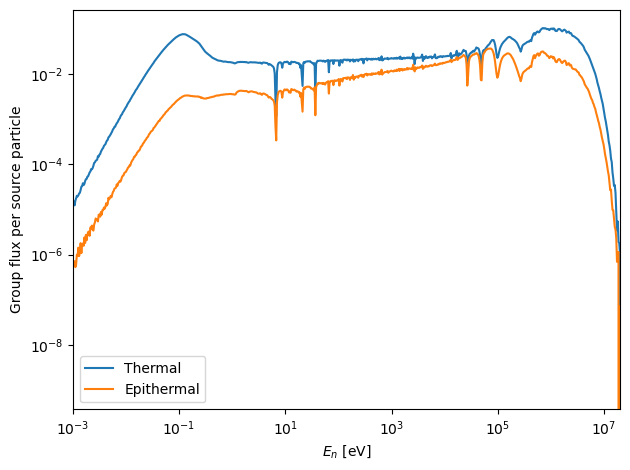

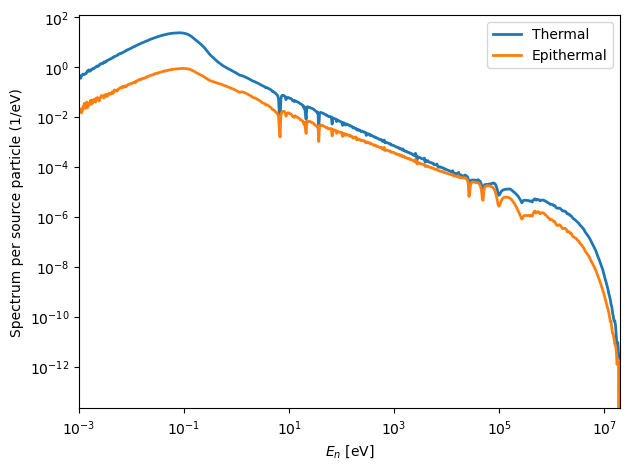

In [30]:
VERSION = "v3"
TEMPERATURE = 900 # K
N_ITERATIONS = 500

TMC_RUN_NAME = "R11" 
FLUX_RUN_NAME = "R12"

# TALLY_INDEX = 3
TALLY_INDEX = 1
# SCORE_STRING = "group_flux"
SCORE_STRING = "spectrum"


MT_to_run_number = {
    2: 1,
    4: 3,
    16: 5,
    22: 7,
    28: 9,
    102: 11,
    103: 13,
    104: 15,
    105: 17,
    107: 19,
}

# Load the .pkl file from the run to get TMC results
tmc_df = pd.read_pickle(f"../runs/{TMC_RUN_NAME}/plotting/tmc_df.pkl")

# for MT_INT in [2, 4, 16, 22, 28, 102, 103, 104, 105, 107]:
for MT_INT in [2, 16, 22, 28, 102, 103, 104, 105, 107]:
    print("WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107")
# for MT_INT in [2, 16]:
    print(f"Handling MT{MT_INT}")
    plt.close('all')

    MT_STRING = f"{MT_INT:03d}"

    res_folder = f"results/MT{MT_INT}"
    os.system(f"rm -rf {res_folder}")
    os.makedirs(res_folder, exist_ok=True)

    df = pd.DataFrame(columns=["energy", "xs"])

    sampled_h5_files_path = f"/home/fne23_stjarnholm/nuclear_data/sandy_samples_v3-MT{MT_INT}"

    # x_logspace = np.logspace(np.log10(1e-2), np.log10(1e7), 1000)
    x_logspace = np.logspace(np.log(1e-3), np.log(2e7), 2001) # 2000 bins between 1e-3 eV and 2e7 eV

    for i in tqdm(range(N_ITERATIONS)):
        h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

        h5file = h5py.File(h5_filename, 'r')
        energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
        reactions_group = h5file[f'F19/reactions']

        xs_group = reactions_group[f'reaction_{MT_STRING}/{TEMPERATURE}K/xs']

        # Extract the cross section and energy data
        xs = xs_group[:]
        XS_LEN = len(xs)
        if len(xs) != len(energy_group[:]):
            energy = energy_group[-len(xs):]
        else:
            energy = energy_group[:]
    
        # Interpolate the cross section to the desired energy grid
        xs = np.interp(x_logspace, energy, xs, left=0, right=0)
        energy = x_logspace

        df = pd.concat([df, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

    # Calculate the means and standard deviations
    df_mean = df.groupby("energy").mean().reset_index()
    df_std = df.groupby("energy").std().reset_index()

    df_flux = pd.DataFrame(columns=["energy", "group_flux", "spectrum", "fast_reactor", "MT"])

    for FAST_REACTOR in [False, True]:
        neutron_temperatue_label = "Thermal" if not FAST_REACTOR else "Epithermal"

        run_number = MT_to_run_number[MT_INT]
        if FAST_REACTOR:
            run_number += 1 # MT2 thermal, is 1, MT2 fast is 2, etc...

        results_dir = f"../runs/{FLUX_RUN_NAME}/results/RUNDATA_{FLUX_RUN_NAME}_{run_number}"

        # Load the run_settings.json file and make sure MT and FAST_REACTOR are correct
        run_settings = run_tools.load_run_settings_json(results_dir)
        assert run_settings["MT"] == MT_INT
        assert run_settings["fast_reactor"] == FAST_REACTOR

        file = f"{results_dir}/statepoint.350.h5"
        sp = openmc.StatePoint(file)

        tallydf=sp.tallies[TALLY_INDEX].get_pandas_dataframe()
        tallydfflux=tallydf[tallydf['score']=='flux']
        energy=(tallydfflux['energy low [eV]']+tallydfflux['energy high [eV]'])/2

        group_flux = tallydfflux['mean']

        plt.figure(1)
        plt.loglog(energy, group_flux, label=neutron_temperatue_label)

        deltaE=(tallydfflux['energy high [eV]']-tallydfflux['energy low [eV]'])
        spectrum = tallydfflux['mean']/deltaE
        
        plt.figure(2)
        plt.loglog(energy, spectrum,lw=2, label=neutron_temperatue_label)

        df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)

    plt.figure(1)
    plt.xlabel('$E_n$ [eV]')
    plt.ylabel('Group flux per source particle')
    plt.xlim(1e-3, 2e7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{res_folder}/group_flux_per_source_particle.pdf")

    plt.figure(2)
    plt.xlabel('$E_n$ [eV]')
    plt.ylabel('Spectrum per source particle (1/eV)')
    plt.xlim(1e-3, 2e7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{res_folder}/spectrum_per_source_particle.pdf")

    # Fold the flux with the std of the sampled data in df_std
    for FAST_REACTOR in [False, True]:
        NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
        print(f"Folding {NEUTRON_TEMP}, MT{MT_INT}")
        df_this_temp = df_flux[df_flux["fast_reactor"] == FAST_REACTOR]

        # Intepolate the flux to the energy grid of the sampled data
        flux = np.interp(df_std["energy"], df_this_temp["energy"], df_this_temp[SCORE_STRING], left=0, right=0)


        # NORMALIZE WITH MEAN
        # Find the indecies where df_mean is non-zero
        non_zero_indecies = np.where(df_mean["xs"] != 0)[0]

        # Fold the flux with the std of the sampled data in df_std, normalized with the mean of the sampled data in df_mean
        # Only fold where the mean is non-zero
        # Make rest of the values 0
        df_std["xs_fw_normalized"] = np.zeros(len(df_std))
        df_std["xs_fw_normalized"].iloc[non_zero_indecies] = df_std["xs"].iloc[non_zero_indecies] * flux[non_zero_indecies] / df_mean["xs"].iloc[non_zero_indecies]


        # DO NOT NORMALIZE WITH MEAN
        # Fold the flux with the std of the sampled data in df_std
        df_std["xs_fw_not_normalized"] = df_std["xs"] * flux

        

        # Integrate the folded cross section
        xs_fw_integrated_normalized = np.trapz(df_std["xs_fw_normalized"], df_std["energy"])
        xs_fw_integrated_not_normalized = np.trapz(df_std["xs_fw_not_normalized"], df_std["energy"])
        print(f"{MT_INT}, {xs_fw_integrated_normalized}")
        print(f"{MT_INT}, {xs_fw_integrated_not_normalized}")
        print(f"{MT_INT}, {np.sum(df_std['xs_fw_normalized'])}")
        print(f"{MT_INT}, {np.sum(df_std['xs_fw_not_normalized'])}")

        # Add the result to the corresponding TMC result
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "sum_xs_fw_normalized"] = np.sum(df_std["xs_fw_normalized"])
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "sum_xs_fw_not_normalized"] = np.sum(df_std["xs_fw_not_normalized"])
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "xs_fw_integrated_normalized"] = xs_fw_integrated_normalized
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "xs_fw_integrated_not_normalized"] = xs_fw_integrated_not_normalized
        

In [31]:
tmc_df.head()

,sigma_obs,sigma2_obs,sigma_stat_mean,sigma2_stat_mean,sigma_ND,sigma2_ND,k_eff_mean,R_obs,R_stat_mean,R_ND,u_k,u_rho,N_ITERATIONS,fast_reactor,MT,MT_label,sum_xs_fw_normalized,sum_xs_fw_not_normalized,xs_fw_integrated_normalized,xs_fw_integrated_not_normalized
0,0.000620,3.843546e-07,0.000315,9.938319e-08,0.000534,2.849714e-07,1.366908,0.000454,0.000231,0.000391,1.3669+/-0.0005,0.26842+/-0.00029,500,False,2,"(n,elastic)",9.220016e+01,3.677448e+02,1.214550,4.224631
1,0.000360,1.296831e-07,0.000315,9.953093e-08,0.000174,3.015221e-08,1.366970,0.000263,0.000231,0.000127,1.36697+/-0.00017,0.26846+/-0.00009,500,False,4,"(n,inelastic)",NaN,NaN,NaN,NaN
2,0.000332,1.101153e-07,0.000315,9.948214e-08,0.000103,1.063319e-08,1.366936,0.000243,0.000231,0.000075,1.36694+/-0.00010,0.26844+/-0.00006,500,False,16,"(n,2n)",1.012206e-09,1.191016e-11,0.000337,0.000004
3,0.000366,1.343042e-07,0.000315,9.897826e-08,0.000188,3.532597e-08,1.366931,0.000268,0.000230,0.000137,1.36693+/-0.00019,0.26843+/-0.00010,500,False,22,"(n,na)",4.406158e-07,1.243662e-08,0.064743,0.002611
4,0.000365,1.331519e-07,0.000315,9.896287e-08,0.000185,3.418907e-08,1.366967,0.000267,0.000230,0.000135,1.36697+/-0.00018,0.26845+/-0.00010,500,False,28,"(n,np)",1.130954e-08,4.601387e-11,0.002958,0.000015


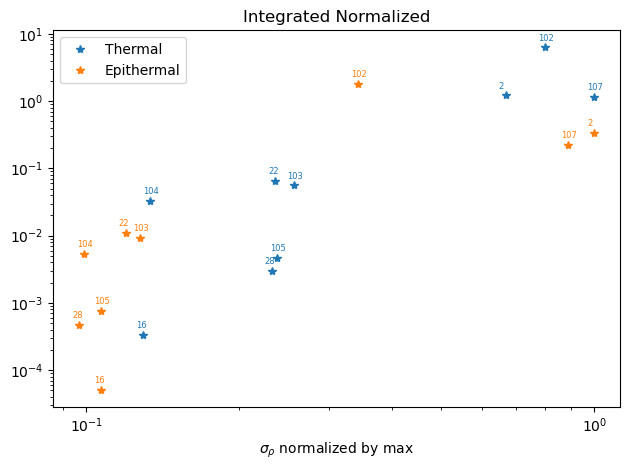

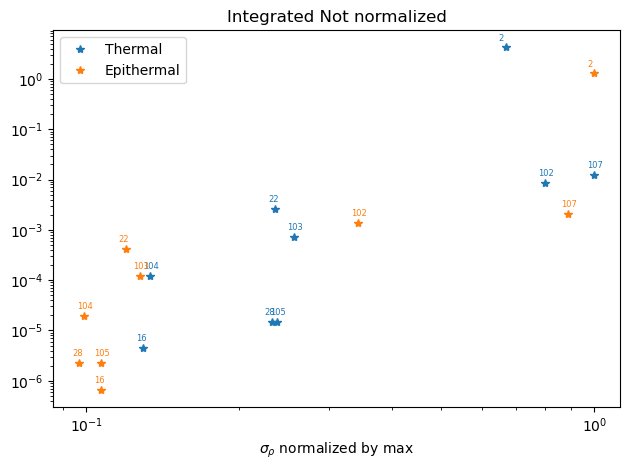

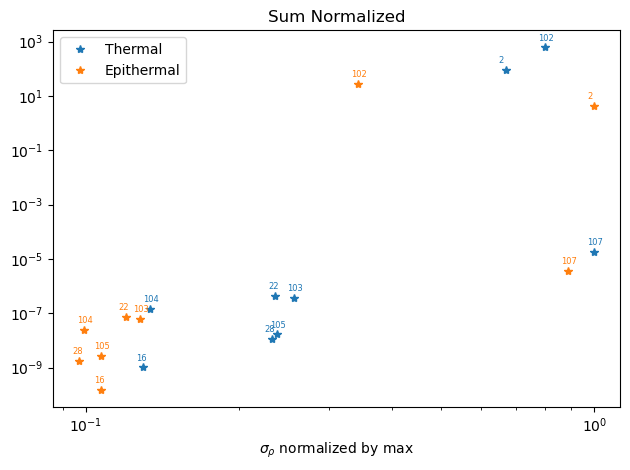

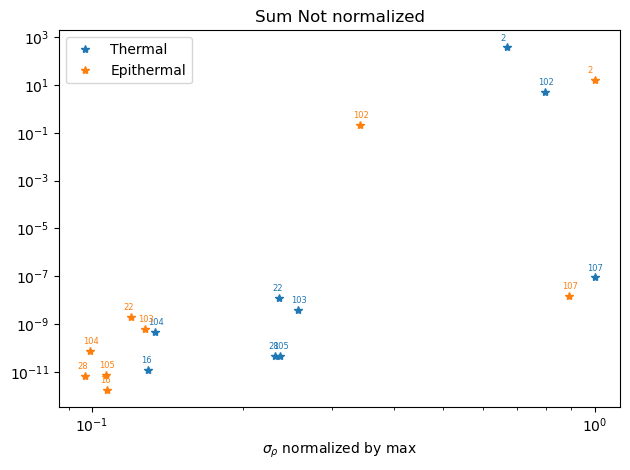

In [32]:
from uncertainties import unumpy

plt.close("all")

save_folder_name = f"results/TALLY{TALLY_INDEX}-{SCORE_STRING}"
os.system(f"rm -r {save_folder_name}")
os.makedirs(save_folder_name, exist_ok=True)

for FAST_REACTOR in [False, True]:
    neutron_temperatue_label = "Thermal" if not FAST_REACTOR else "Epithermal"
    df_thistemp = tmc_df[tmc_df["fast_reactor"] == FAST_REACTOR]

    x_axis = unumpy.std_devs(df_thistemp["u_rho"]) * 1e5
    x_axis = x_axis / np.max(x_axis) # Normalize to 1

    
    plt.figure(1)
    plt.loglog(x_axis, df_thistemp["xs_fw_integrated_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Integrated Normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()
    
    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["xs_fw_integrated_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)


    plt.figure(2)
    plt.loglog(x_axis, df_thistemp["xs_fw_integrated_not_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Integrated Not normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["xs_fw_integrated_not_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

    plt.figure(3)
    plt.loglog(x_axis, df_thistemp["sum_xs_fw_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Sum Normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["sum_xs_fw_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

    plt.figure(4)
    plt.loglog(x_axis, df_thistemp["sum_xs_fw_not_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Sum Not normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["sum_xs_fw_not_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

plt.figure(1)
plt.savefig(f"{save_folder_name}/integrated_normalized.png")

plt.figure(2)
plt.savefig(f"{save_folder_name}/integrated_not_normalized.png")

plt.figure(3)
plt.savefig(f"{save_folder_name}/sum_normalized.png")

plt.figure(4)
plt.savefig(f"{save_folder_name}/sum_not_normalized.png")